In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# 귀여운 고양이에 대한 아웃포커싱 사진

(1980, 3520, 3)


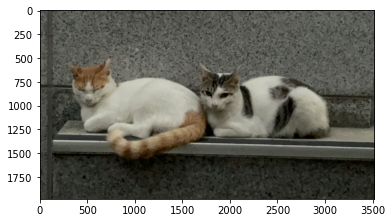

In [2]:
img_path = '/aiffel/aiffel/human_segmentation/images/cats.JPG'

img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

In [3]:
model_file = '/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
#PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model = semantic_segmentation() 
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file) 
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [4]:
segvalues
# 0 : background, 8 : cat

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [5]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 
    'bottle', 'bus','car', 'cat', 'chair', 
    'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [6]:
# cat에 대해서 확인
print(segvalues['class_ids'][1])
print(segvalues['masks'][1])
mask = segvalues['masks'][1]

8
[False False False ... False False False]


In [7]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [8]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [9]:
# 8번째 색상 RGB로 분리
R , G , B = colormap[8][0],colormap[8][1], colormap[8][2]
print(R,G,B)

64 0 0


In [10]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color = (B,G,R) 

(1980, 3520)


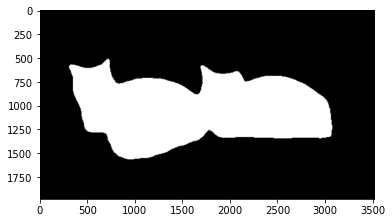

In [11]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

In [12]:
seg_map

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

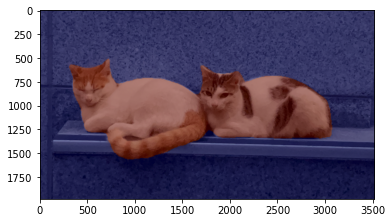

In [13]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

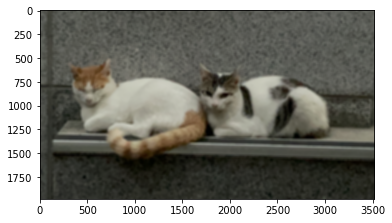

In [14]:
# blur filter size 조정
img_orig_blur = cv2.blur(img_orig, (30,30))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

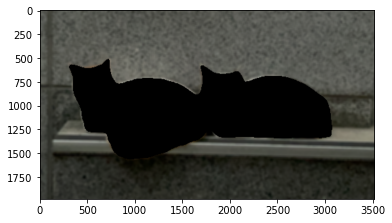

In [15]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 
# 배경이 0 사람이 255 였으나 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

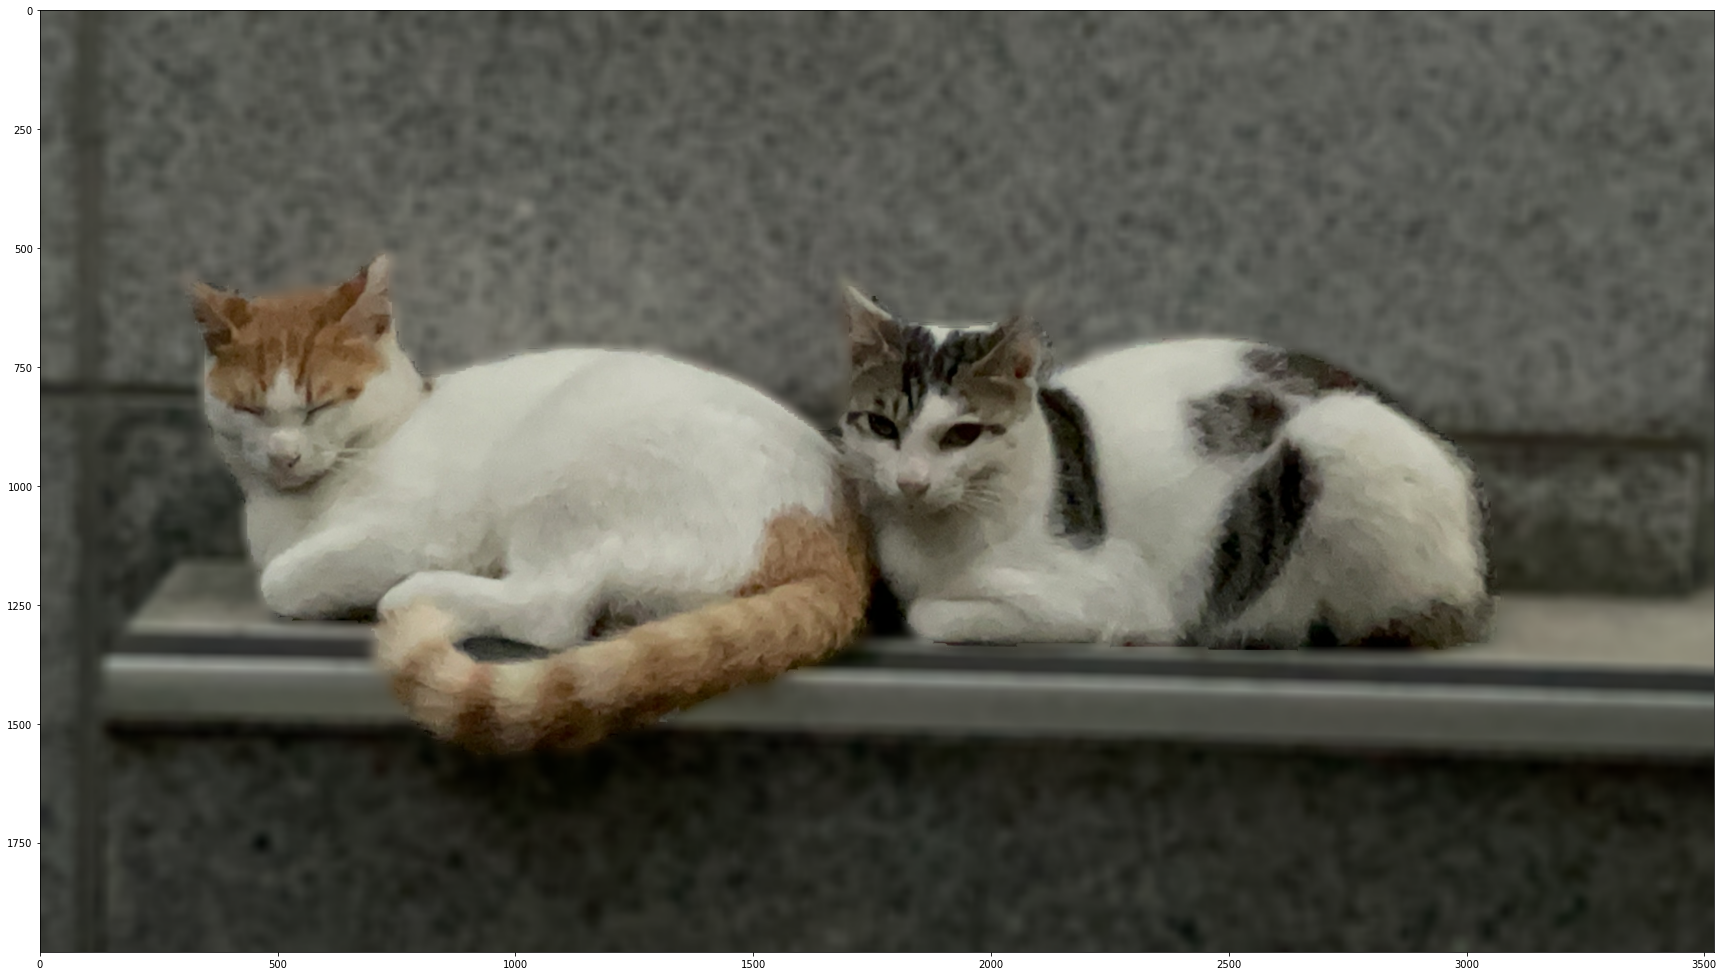

In [16]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

# 크게 확인
plt.figure(figsize = (30, 30))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

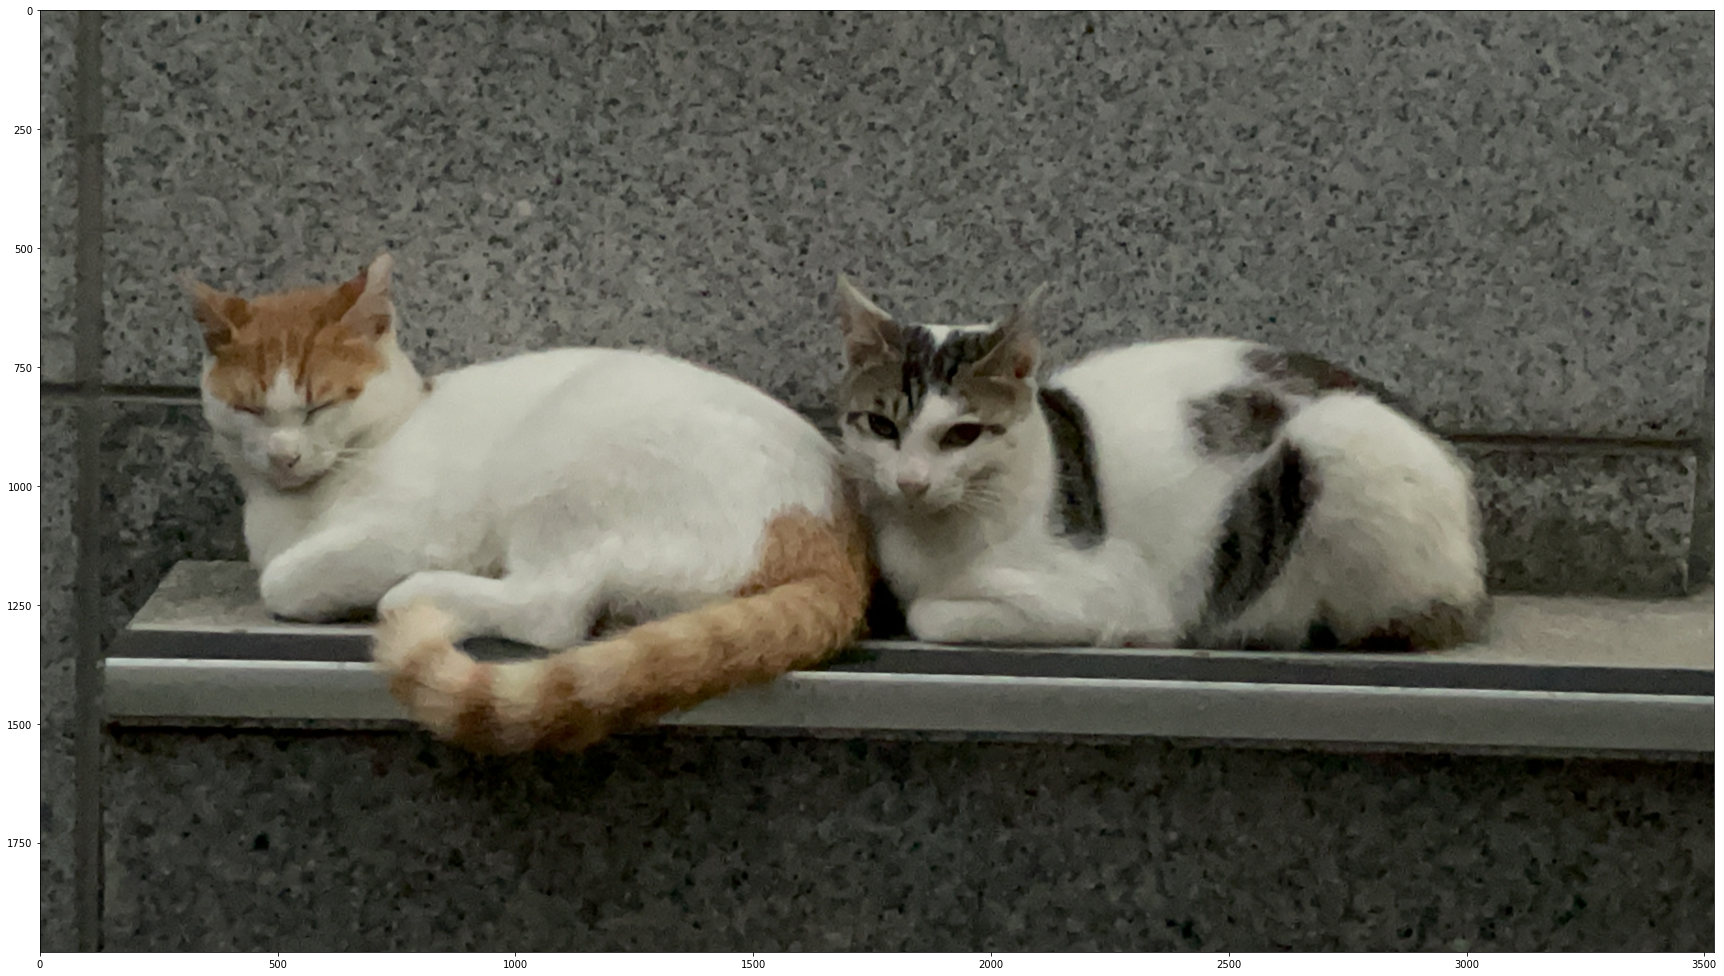

In [17]:
plt.figure(figsize = (30, 30))
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
# 아웃포커싱이 되긴 했는데 배경이 단순해서 구분히 확 가진 않네

# 크로마키 배경 합성

In [18]:
import glob
glob.glob(img_path+'*')

['/aiffel/aiffel/human_segmentation/images/cats.JPG']

(3474, 5257, 3)


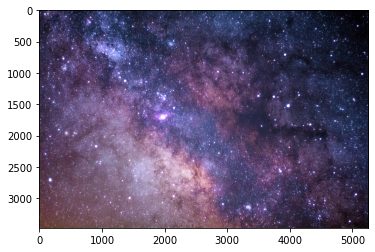

(4032, 2268, 3)


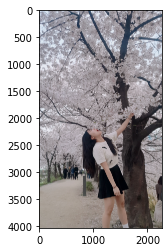

In [74]:
img_path = '/aiffel/aiffel/human_segmentation/images/'


# 배경화면
bg_img = cv2.imread(img_path+'back.jpg') 
print(bg_img.shape)
plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
plt.show()

# 합성할 사진
pls_img = cv2.imread(img_path+'IMG_1496.JPG') 

print(pls_img.shape)
plt.imshow(cv2.cvtColor(pls_img, cv2.COLOR_BGR2RGB))
plt.show()

In [75]:
# ERROR : path 로 넘겨줘야 하네 
'''
    127         image = image_path
    128       else:
--> 129         image = np.array(Image.open(image_path))
'''
segvalues, output = model.segmentAsPascalvoc(img_path+'IMG_1496.JPG')

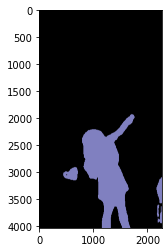

{'class_ids': array([ 0, 15]), 'masks': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
background
person


In [76]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 
    'bottle', 'bus','car', 'cat', 'chair', 
    'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

# 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

# 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력
print(segvalues)

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

(4032, 2268)


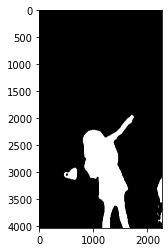

In [77]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

person = colormap[15]
R , G , B = person[0], person[1], person[2]
# RGB->BGR
seg_color = (B,G,R)

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 

plt.imshow(seg_map, cmap='gray')
plt.show()

In [71]:
seg_map

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

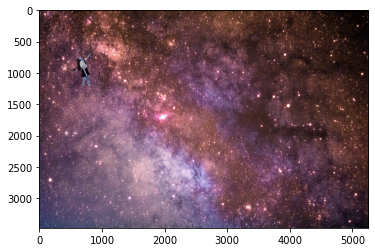

In [86]:
# 원본이미지 복사
pls_img_copy = pls_img.copy()

img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)


# 객체만 남기고 나머지는 0(검은색) 처리
only_img_concat = np.where(img_mask_color==255, pls_img_copy, 0)

# 고양이 resize
h, w, c = only_img_concat.shape
img_resize = cv2.resize(only_img_concat, (w//4, h//4), cv2.INTER_AREA)
h,w,c = img_resize.shape[0], img_resize.shape[1], img_resize.shape[0]


back_img_show = bg_img.copy()

refined_y = 200
refined_x = 400

alpha = 0 # 투명도

sticker_area = back_img_show[refined_y:refined_y+img_resize.shape[0], refined_x:refined_x+img_resize.shape[1]]
back_img_show[refined_y:refined_y +img_resize.shape[0], refined_x:refined_x+img_resize.shape[1]] = \
cv2.addWeighted(sticker_area, alpha, np.where(img_resize==0,sticker_area,img_resize).astype(np.uint8), 1-alpha, 0)  # 컬러 값 0(검은색)

plt.imshow(back_img_show)
plt.show()

#아주 쪼꼬미로 저 구석에 떠다니규 있군><

# 최소 3장 이상의 인물모드 사진 인물모드

In [ ]:
# 여기서부터는 함수화해서 하는게 편할듯

# 회고

In [ ]:
'''
시간내에 다 하지 못해서 아쉽네요.
나중에 추가하도록 하겠습니다
'''